In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Data Preprossesing

reading the data

In [7]:
training_data = pd.read_csv('train.csv')

#exploring the data 
print(training_data.shape)

print(training_data.info())

print(training_data.isna().sum())
print(training_data.columns)

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
d

 the number of missing values in age is not that big so we can fill these values with the mean \
 the number of missing values in cabin is more than 50% -->col. will be droped \
 the two missing values in Embarked column will be droped \
 ticket & name is uniqu so there is no point of having them --> col.s will be droped


In [8]:
#calculating the mean 
mean_of_age = training_data['Age'].mean()

#filling the Age column with the mean
training_data['Age'] = training_data['Age'].fillna(mean_of_age)

#droping the Cabin, name and ticket col
training_data = training_data.drop(['PassengerId','Cabin','Name','Ticket'],axis=1)

#droping the missng rows
training_data = training_data.dropna()

print(training_data.shape)
print(training_data.head(10))


(889, 8)
   Pclass     Sex        Age  SibSp  Parch     Fare Embarked  Survived
0       3    male  22.000000      1      0   7.2500        S         0
1       1  female  38.000000      1      0  71.2833        C         1
2       3  female  26.000000      0      0   7.9250        S         1
3       1  female  35.000000      1      0  53.1000        S         1
4       3    male  35.000000      0      0   8.0500        S         0
5       3    male  29.699118      0      0   8.4583        Q         0
6       1    male  54.000000      0      0  51.8625        S         0
7       3    male   2.000000      3      1  21.0750        S         0
8       3  female  27.000000      0      2  11.1333        S         1
9       2  female  14.000000      1      0  30.0708        C         1


is there any outlier in this data ? --> only one way to find out \
we will plot the data do find any outlier

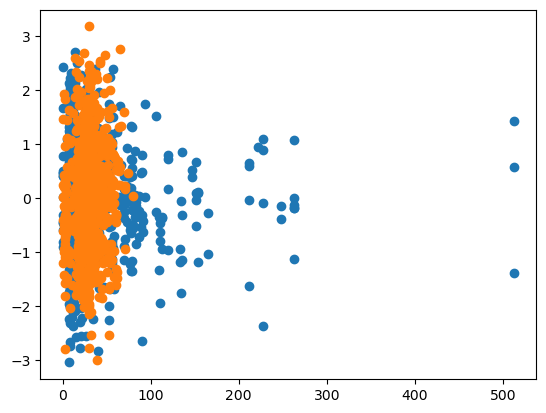

In [9]:
np.random.seed(0)

f = np.random.randn(len(training_data['Fare']))
plt.scatter(training_data['Fare'],f)

z = np.random.randn(len(training_data['Age']))
plt.scatter(training_data['Age'],z)

plt.show()

age is clean but there is 3 outliers in (Fare)

In [10]:
print(training_data[training_data['Fare']>400])

     Pclass     Sex   Age  SibSp  Parch      Fare Embarked  Survived
258       1  female  35.0      0      0  512.3292        C         1
679       1    male  36.0      0      1  512.3292        C         1
737       1    male  35.0      0      0  512.3292        C         1


it is weird that 3 passengers have the same fare and the same ticket number(512) --> we are gonna drop these rows

In [11]:
training_data = training_data[training_data['Fare']<400]
print(training_data.shape)

(886, 8)


In [12]:
#CHANGING THE SEX CATEGORIES FROM MALEs AND FEMALEs TO 1s AND 0s
training_data['Sex'] = training_data['Sex'].replace({'male': 1, 'female': 0})

print(training_data.head())

#DETERMINING HOW MANY CATEGRIES IN EMBARKED

print(training_data["Embarked"].nunique())

print(training_data["Embarked"].unique())



   Pclass  Sex   Age  SibSp  Parch     Fare Embarked  Survived
0       3    1  22.0      1      0   7.2500        S         0
1       1    0  38.0      1      0  71.2833        C         1
2       3    0  26.0      0      0   7.9250        S         1
3       1    0  35.0      1      0  53.1000        S         1
4       3    1  35.0      0      0   8.0500        S         0
3
['S' 'C' 'Q']


Now we know that we have 3 Categorries ['S','C','Q'] \
WE MARK 'S' AS 0 \
        'C' AS 1  
        'Q' AS 2 

In [13]:
training_data['Embarked'] = training_data['Embarked'].map({'S': 0, 'C': 1, 'Q':2})
print(training_data.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  22.0      1      0   7.2500         0         0
1       1    0  38.0      1      0  71.2833         1         1
2       3    0  26.0      0      0   7.9250         0         1
3       1    0  35.0      1      0  53.1000         0         1
4       3    1  35.0      0      0   8.0500         0         0


# NOW for the KNN -- HERE WE GO 🚨🚨

In [14]:
x = training_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].values
y = training_data['Survived'].values


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=21, stratify=y)
knn = knc(n_neighbors = 22)
knn.fit(x_train,y_train)
print(knn.score(x_test,y_test))


0.6797752808988764


VERY BAD SCORE \
LET ME IMPROVE IT

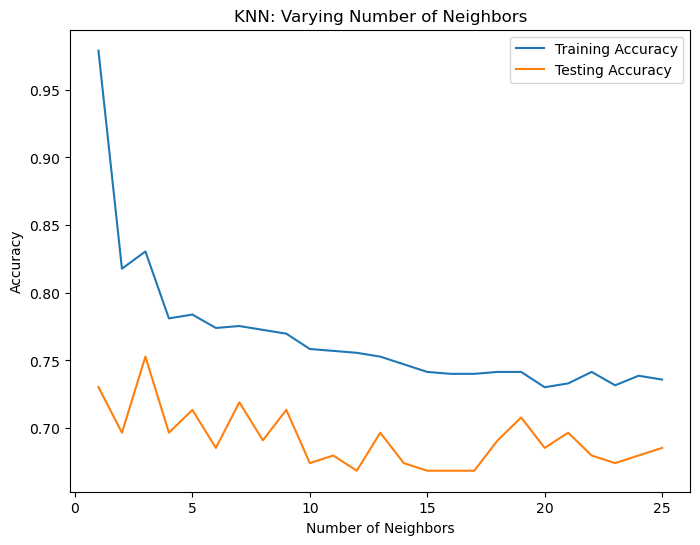

In [16]:
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1,26)

for neighbor in neighbors:
    knn = knc(n_neighbors=neighbor)
    knn.fit(x_train,y_train)
    train_accuracies[neighbor] = knn.score(x_train,y_train)
    test_accuracies[neighbor] = knn.score(x_test,y_test)

# WE PLOT THE DATA TO GET THE BEST NUMBER OF NEIGHBORS

plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()


The best number of neighbors is 3 according to the plot

In [17]:

knn = knc(n_neighbors = 3)
knn.fit(x_train,y_train)
print(knn.score(x_test,y_test))

0.7528089887640449


# The Accuracy

In [18]:
knn = knc(n_neighbors=3)
knn.fit(x_train,y_train)
#train_accuracies[neighbor] = knn.score(x_train,y_train)
#test_accuracies[neighbor] = knn.score(x_test,y_test)


y_pred = knn.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[94 16]
 [28 40]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       110
           1       0.71      0.59      0.65        68

    accuracy                           0.75       178
   macro avg       0.74      0.72      0.73       178
weighted avg       0.75      0.75      0.75       178



# NOW FOR THE NAIVE BAYS

In [19]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7640449438202247
[[90 20]
 [22 46]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       110
           1       0.70      0.68      0.69        68

    accuracy                           0.76       178
   macro avg       0.75      0.75      0.75       178
weighted avg       0.76      0.76      0.76       178



In [26]:
svm_model = SVC(kernel = 'linear', random_state=21)
svm_model.fit(x_train,y_train)
y_pred = svm_model.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[92 18]
 [22 46]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       110
           1       0.72      0.68      0.70        68

    accuracy                           0.78       178
   macro avg       0.76      0.76      0.76       178
weighted avg       0.77      0.78      0.77       178

